In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import starfile

In [2]:
tomos = pd.read_csv('~/working/AAA1_tomos.csv', header=None)
thickness_nm = pd.read_csv('~/working/AAA1_thickness_nm.csv', header=None, dtype=float)
thickness_stddev = pd.read_csv('~/working/AAA1_thickness_stddev.csv', header=None, dtype=float)

In [3]:
tomo_thicknesses = pd.DataFrame([tomos[0], thickness_nm[0], thickness_stddev[0]]).T

tomo_thickness_dict = {}
for idx, row in tomo_thicknesses.iterrows():
    tomo_thickness_dict[tomo_thicknesses.iloc[idx].values[0]] = [tomo_thicknesses.iloc[idx].values[1], tomo_thicknesses.iloc[idx].values[2]]
tomo_thickness_dict

{'ts_003': [232.376666666667, 22.2703164618849],
 'ts_004': [260.040555555556, 11.7312460560581],
 'ts_005': [154.677222222222, 12.059609267901],
 'ts_006': [303.460833333333, 33.1269762146351],
 'ts_007': [246.328888888889, 17.2021402243619],
 'ts_008': [213.011944444444, 10.5200090436167],
 'ts_009': [249.576388888889, 34.4794140147221],
 'ts_012': [259.439166666667, 21.9122707845969],
 'ts_013': [179.093611111111, 17.2616421361385],
 'ts_014': [192.805277777778, 10.7222764930981],
 'ts_015': [305.385277777778, 9.50574994119057],
 'ts_016': [313.443888888889, 29.8577319108654],
 'ts_017': [207.719722222222, 16.5718380017711],
 'ts_018': [250.658888888889, 8.91192592042321],
 'ts_020': [229.850833333333, 11.9688476497322],
 'ts_021': [263.167777777778, 11.0585262244543],
 'ts_022': [255.349722222222, 35.3409495009959],
 'ts_023': [234.180833333333, 21.4050518277812],
 'ts_024': [347.602777777778, 54.9400596025518],
 'ts_026': [199.540833333333, 8.47190254975233],
 'ts_027': [281.32972

In [4]:
input_star = Path("/mnt/scratch/ribosomes/kas_k44a/relion_full/CtfRefineTomo/estimate_ice/tomograms.star")
particles_df = starfile.read(input_star)["global"]

In [5]:
# Add columns for tomo thickness and stddev
# Match rlnTomoName in both tables and input the rlnTomoThicknessNm and rlnTomoThicknessStddevNm

particles_df["TomoThicknessNm"] = 0.0
particles_df["TomoThicknessStddevNm"] = 0.0

#only do 5 iterrows
for idx, row in particles_df.iterrows():
    ts_name = particles_df.iloc[idx]["rlnTomoName"]
    particles_df.at[idx, "TomoThicknessNm"] = tomo_thickness_dict[ts_name][0]
    particles_df.at[idx, "TomoThicknessStddevNm"] = tomo_thickness_dict[ts_name][1]

# print the row with the max value of TomoThicknessNm
particles_df.loc[particles_df['TomoThicknessNm'].idxmax()]

rlnTomoName                                            ts_024
rlnTomoTiltSeriesName          ../tomograms/ts_024/ts_024.mrc
rlnTomoFrameCount                                          51
rlnTomoSizeX                                             8184
rlnTomoSizeY                                            11520
rlnTomoSizeZ                                             4800
rlnTomoHand                                              -1.0
rlnOpticsGroupName                               opticsGroup1
rlnTomoTiltSeriesPixelSize                             1.0825
rlnVoltage                                              300.0
rlnSphericalAberration                                    2.7
rlnAmplitudeContrast                                     0.07
rlnTomoImportFractionalDose                               2.4
rlnTomoRelativeLuminance                             2.402947
rlnTomoRelativeIceThickness                          2.370096
rlnTomoIceNormalX                                    0.014806
rlnTomoI

In [6]:
starfile.write(particles_df, "/mnt/scratch/ribosomes/kas_k44a/relion_full/tomogram_info.star", overwrite=True)

In [77]:
x_data = np.arange(len(particles_df["rlnTomoName"].index)) + 1
y1_data = particles_df["TomoThicknessNm"]
dy1_data = particles_df["TomoThicknessStddevNm"]
y2_data = particles_df["rlnTomoRelativeIceThickness"]

error_weighted_mean = np.mean(y1_data/dy1_data**2)/np.mean(1/dy1_data)**2
print(error_weighted_mean/np.mean(y2_data))
y_data = y1_data/y2_data
dy_data = dy1_data/y2_data

168.75697099137832


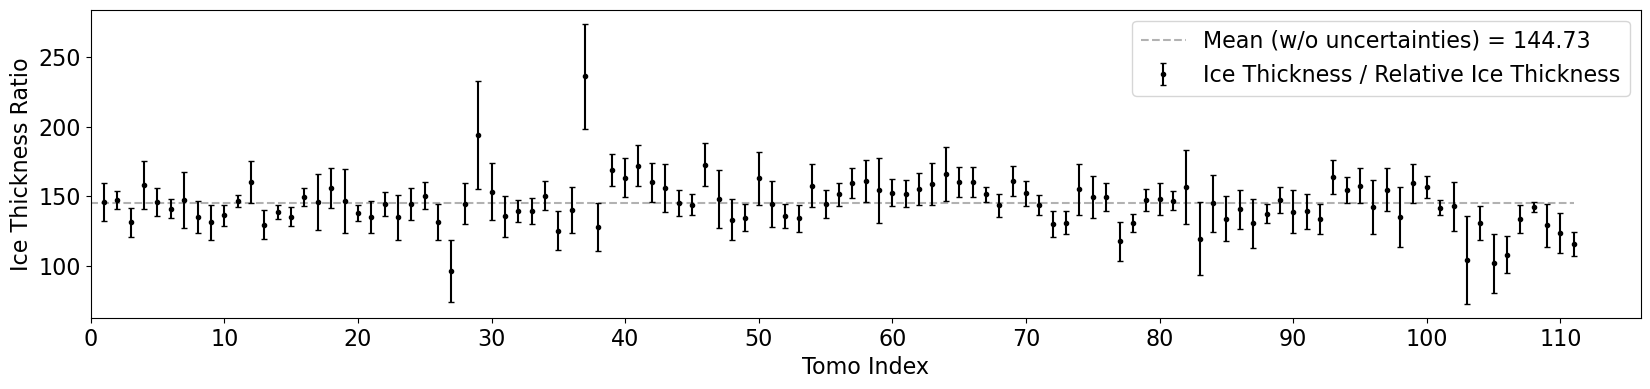

In [86]:
plt.figure(figsize=(20,4))
plt.rcParams['font.size'] = 16
plt.errorbar(x_data, y_data, yerr=dy_data, fmt='.', markersize=6, color='black', alpha=1, label='Ice Thickness / Relative Ice Thickness', capsize=2)
plt.hlines(np.mean(y_data), -5, len(particles_df["rlnTomoName"].index), colors='k', alpha=0.3, linestyles='dashed', label=f'Mean (w/o uncertainties) = {np.mean(y_data):.2f}')
#plt.hlines(error_weighted_mean/np.mean(y2_data), -5, len(particles_df["rlnTomoName"].index), colors='r', alpha=0.3, linestyles='dashed', label=f'Error-weighted Mean = {error_weighted_mean/np.mean(y_data):.2f}')
#plt.annotate('Mean', xy=(len(particles_df["TomoThicknessNm"]), np.mean(y_data)), xytext=(len(particles_df["TomoThicknessNm"])-4, np.mean(y_data)+10), fontsize=14)
plt.xticks(np.arange(0, len(particles_df["rlnTomoName"].index), 10))
plt.ylabel("Ice Thickness Ratio")
plt.xlabel("Tomo Index")
plt.xlim(0, len(particles_df["rlnTomoName"].index)+5)
plt.legend()
plt.savefig("/mnt/scratch/ribosomes/kas_k44a/relion_full/ice_thickness_ratio.png", dpi=300, bbox_inches='tight')

In [ ]:
x_data = np.arange(len(particles_df["rlnTomoName"].index))
#y1_data = (particles_df["TomoThicknessNm"] - min(particles_df["TomoThicknessNm"]))/(max(particles_df["TomoThicknessNm"]) - min(particles_df["TomoThicknessNm"]))
y1_data = particles_df["TomoThicknessNm"]/max(particles_df["TomoThicknessNm"])
dy1_data = particles_df["TomoThicknessStddevNm"]/max(particles_df["TomoThicknessNm"])
#dy1_data = y1_data* np.sqrt((particles_df["TomoThicknessStddevNm"]/particles_df["TomoThicknessNm"])**2 + (54.94006/max(particles_df["TomoThicknessNm"]))**2)
y2_data = particles_df["rlnTomoRelativeIceThickness"]/max(particles_df["rlnTomoRelativeIceThickness"])

In [ ]:
plt.figure(figsize=(20,4))
plt.errorbar(x_data, y1_data, yerr=dy1_data, fmt='o', label="Ice_Thickness / max(Ice_Thickness)")
plt.plot(x_data, y2_data, 'o', label="Rel_Ice_Thickness / max(Rel_Ice_Thickness)")
plt.xlabel("Tomo Index")
plt.legend()
plt.ylim(0,1.2)

In [9]:
x_data = particles_df["rlnTomoName"]
y1_data = (particles_df["TomoThicknessNm"] - min(particles_df["TomoThicknessNm"]))/(max(particles_df["TomoThicknessNm"]) - min(particles_df["TomoThicknessNm"]))
#y1_data = particles_df["TomoThicknessNm"]/max(particles_df["TomoThicknessNm"])
dy1_data = 0#(particles_df["TomoThicknessStddevNm"])/(max(particles_df["TomoThicknessStddevNm"]) - min(particles_df["TomoThicknessStddevNm"]))
#y2_data = particles_df["rlnTomoRelativeIceThickness"]/max(particles_df["rlnTomoRelativeIceThickness"])
y2_data = (particles_df["rlnTomoRelativeIceThickness"] - min(particles_df["rlnTomoRelativeIceThickness"]))/(max(particles_df["rlnTomoRelativeIceThickness"]) - min(particles_df["rlnTomoRelativeIceThickness"]))

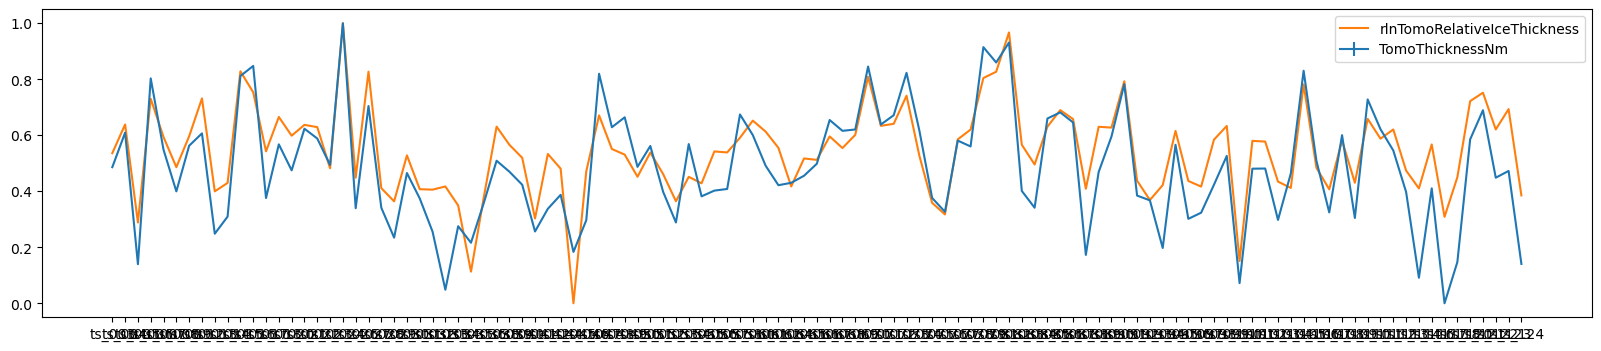

In [10]:
plt.figure(figsize=(20,4))
plt.errorbar(x_data, y1_data, yerr=dy1_data, fmt='-', label="TomoThicknessNm")
plt.plot(x_data, y2_data, '-', label="rlnTomoRelativeIceThickness")
plt.legend()